Installations

In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torchvision import datasets, transforms, models
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tempfile
import sys

from collections import Counter
from functools import partial
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Optional, List, Sequence, Union
from PIL import Image
from tqdm import tqdm

from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes

import monai
from monai.transforms import Compose, LoadImage, ScaleIntensity, Resize, RandSpatialCrop, RandRotate90
import timm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete
from monai.visualize import plot_2d_or_3d_image
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandRotate90d,
    RandSpatialCropd,
    ScaleIntensityd,
    Resized,
    EnsureChannelFirstd,
    Lambdad,

    RandFlipd,
    RandRotate90d,
    RandRotateD,
)

import time
import copy
import os
import shutil
import glob
from pathlib import Path

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Dataset

In [3]:
!unzip /content/drive/MyDrive/archaide.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Dr18/A10151/f_A10151_20191205_111414.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._f_A10151_20191205_111414.jpg  
  inflating: dataset/Dr18/A10151/f_A10151_20191205_111401.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._f_A10151_20191205_111401.jpg  
  inflating: dataset/Dr18/A10151/t_A10151_20191205_111223.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._t_A10151_20191205_111223.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111232.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A10151_20191205_111232.jpg  
  inflating: dataset/Dr18/A10151/t_A10151_20191205_111154.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._t_A10151_20191205_111154.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111148.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A10151_20191205_111148.jpg  
  inflating: dataset/Dr18/A10151/s_A10151_20191205_111228.jpg  
  inflating: __MACOSX/dataset/Dr18/A10151/._s_A1015

In [4]:
dataset_path = '/content/dataset/'
dataset_path = Path(dataset_path)

for class_folder in dataset_path.iterdir():
  if class_folder.is_dir():
    for sample_folder in class_folder.iterdir():
      if sample_folder.is_dir():
        for image_file in sample_folder.iterdir():
          if image_file.is_file() and image_file.suffix.lower() in ['.jpg', '.jpeg']:
            new_image_name = f"{sample_folder.name}_{image_file.name}"
            destination = class_folder / new_image_name

            counter=1
            while destination.exists():
              new_image_name = f"{sample_folder.name}_{image_file.stem}_{counter}{image_file.suffix}"
              destination = class_folder / new_image_name
              counter += 1

            shutil.move(str(image_file), str(destination))

        sample_folder.rmdir()

In [5]:
dataset_dir = '/content/dataset/'
masks_dir = '/content/mask'

os.makedirs('/content/data/image', exist_ok=True)
os.makedirs('/content/data/mask', exist_ok=True)

count = 0
for folder in glob.glob(f'{dataset_dir}/*'):
  list1 = glob.glob(f'{folder}/*.jpg')
  list1 = list(list1)
  print(f"directory {folder} has length {len(list1)}")

directory /content/dataset/Dr37 has length 183
directory /content/dataset/Dr29 has length 623
directory /content/dataset/Dr18 has length 1864
directory /content/dataset/Dr33 has length 418
directory /content/dataset/Dr36 has length 511
directory /content/dataset/Dr35 has length 339
directory /content/dataset/Dr24-25 has length 270
directory /content/dataset/Dr38 has length 229
directory /content/dataset/Dr27 has length 841


Creating masks

In [6]:
def load_image(image_path):
  image = cv2.imread(image_path)
  return image

def create_orange_mask(image, threshold_blue):
  threshold_blue = int(threshold_blue)
  threshold_blue = max(0, min(threshold_blue, 255))

  lower_orange = np.array([threshold_blue, 100, 100], dtype=image.dtype)
  upper_orange = np.array([255, 255, 255], dtype=image.dtype)

  mask = cv2.inRange(image, lower_orange, upper_orange)
  return mask

def extract_largest_region(mask):
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
  if num_labels <= 1:
    return mask
  largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
  largest_mask = (labels == largest_label).astype(np.uint8) * 255
  return largest_mask

def fill_mask_holes(mask):
  filled_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
  return filled_mask

def process_image(image_path, image_save_dir, mask_save_dir, resize_dim=(224, 224)):
  image = load_image(image_path)
  image_resized = cv2.resize(image, dsize=resize_dim, interpolation=cv2.INTER_CUBIC)

  class_folder = os.path.basename(os.path.dirname(image_path))
  image_filename = os.path.basename(image_path)
  image_output_dir = os.path.join(image_save_dir, class_folder)
  os.makedirs(image_output_dir, exist_ok=True)
  image_output_path = os.path.join(image_output_dir, image_filename)
  cv2.imwrite(image_output_path, image_resized)

  threshold = np.percentile(image_resized, 15)
  mask = create_orange_mask(image_resized, threshold_blue=threshold)
  largest_mask = extract_largest_region(mask)
  filled_mask = fill_mask_holes(largest_mask).astype(np.uint8)
  # filled_mask = fill_mask_holes(largest_mask).astype(np.uint8) * 255

  filled_mask = ~filled_mask


  unique_values = np.unique(filled_mask)

  mask_output_dir = os.path.join(mask_save_dir, class_folder)
  os.makedirs(mask_output_dir, exist_ok=True)
  mask_output_path = os.path.join(mask_output_dir, image_filename)
  cv2.imwrite(mask_output_path, filled_mask)

  # return True

  return filled_mask, image_resized

In [7]:
imagedir = '/content/data/image'
maskdir = '/content/data/mask'

os.makedirs(imagedir, exist_ok=True)
os.makedirs(maskdir, exist_ok=True)

image_paths = []
for folder in glob.glob(os.path.join(dataset_dir, '*')):
  #HYPERPARAMETER: set to either 20 for testing, 400 for optimal operation, and 600 for 'nearly' unconstrianed operation.
  folder_images = glob.glob(os.path.join(folder, '*.jpg'))[:400]
  image_paths.extend(folder_images)

num_workers = min(32, os.cpu_count() + 4)
total_images = len(image_paths)

with ProcessPoolExecutor(max_workers=num_workers) as executor:
  process_func = partial(process_image, image_save_dir=imagedir, mask_save_dir=maskdir)
  futures = {executor.submit(process_func, img_path): img_path for img_path in image_paths}
  with tqdm(total=total_images, desc="Processing Images", unit="image") as pbar:
    processed = 0
    successes = 0
    for future in as_completed(futures):
      img_path = futures[future]
      result = future.result()
      processed += 1
      if result:
        successes += 1
      pbar.update(1)
      pbar.set_postfix({"Successes": successes})

Processing Images: 100%|██████████| 3021/3021 [00:15<00:00, 198.20image/s, Successes=3021]


UNet Model Architecture

In [8]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels: int, skip_channels: int, out_channels: int):
    super(DecoderBlock, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True)

  def forward(self, x: torch.Tensor, skip: Optional[torch.Tensor]) -> torch.Tensor:
    x = self.up(x)
    if skip is not None:
      if x.size() != skip.size():
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
      x = torch.cat([x, skip], dim=1)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    return x

class UNetTimmWithClassification(nn.Module):
  def __init__(self,
      encoder_name: str = 'resnet34',
      encoder_weights: Optional[str] = 'imagenet',
      num_classes_seg: int = 1,
      num_classes_cls: int = 5
  ):

      super(UNetTimmWithClassification, self).__init__()

      self.encoder = timm.create_model(
          encoder_name,
          pretrained=(encoder_weights == 'imagenet'),
          features_only=True,
          in_chans=3
      )

      encoder_channels = self.encoder.feature_info.channels()
      decoder_channels = [2048, 1024, 512, 256]
      # decoder_channels = [512, 256, 128, 64]

      self.decoder4 = DecoderBlock(
          in_channels=decoder_channels[0],
          skip_channels=encoder_channels[3],
          out_channels=decoder_channels[1]
      )
      self.decoder3 = DecoderBlock(
          in_channels=decoder_channels[1],
          skip_channels=encoder_channels[2],
          out_channels=decoder_channels[2]
      )
      self.decoder2 = DecoderBlock(
          in_channels=decoder_channels[2],
          skip_channels=encoder_channels[1],
          out_channels=decoder_channels[3]
      )
      self.decoder1 = DecoderBlock(
          in_channels=decoder_channels[3],
          skip_channels=encoder_channels[0],
          out_channels=decoder_channels[3]
      )
      self.final_up = nn.ConvTranspose2d(
          in_channels=decoder_channels[-1],
          out_channels=32,
          kernel_size=2,
          stride=2
      )
      self.final_conv_seg = nn.Conv2d(
          in_channels=32,
          out_channels=num_classes_seg,
          kernel_size=1
      )

      #Cls head
      self.classification_head = nn.Sequential(
          nn.AdaptiveAvgPool2d(1),
          nn.Flatten(),
          nn.Linear(2048, 512),
          # nn.Linear(encoder_channels[-1], 512),
          nn.Dropout(0.2),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, num_classes_cls)
      )

      if num_classes_cls > 1:
          self.classification_activation = nn.Softmax(dim=1)
      elif num_classes_cls == 1:
          self.classification_activation = nn.Sigmoid()
      else:
          self.classification_activation = None

      if self.classification_activation is not None:
          self.classification_head.add_module("activation", self.classification_activation)

      #Xavier weight initialize
      if encoder_weights == 'xavier':
        self.apply(self.xavier_init_weights)

  def xavier_init_weights(self, m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
      nn.init.ones_(m.weight)
      nn.init.zeros_(m.bias)

  def forward(self, x: torch.Tensor) -> tuple:
    features = self.encoder(x)
    C0, C1, C2, C3, C4 = features
    cls = self.classification_head(C4)
    D4 = self.decoder4(C4, C3)
    D3 = self.decoder3(D4, C2)
    D2 = self.decoder2(D3, C1)
    D1 = self.decoder1(D2, C0)
    x = self.final_up(D1)
    seg = self.final_conv_seg(x)
    return seg, cls

Dataset class

In [9]:
class ImageSegDataset(Dataset):
  def __init__(self, images, segs, class_to_idx, transform=None):
    self.image_paths = images
    self.mask_paths = segs
    self.class_to_idx = class_to_idx
    self.transform = transform
  def __len__(self):
    return len(self.image_paths)
  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    mask_filepath = self.mask_paths[idx]
    data = {'image': image_filepath, 'mask': mask_filepath}

    if self.transform is not None:
      data = self.transform(data)
    image = data['image']
    mask = data['mask']

    class_name = os.path.basename(os.path.dirname(image_filepath))
    label = self.class_to_idx.get(class_name, -1)
    return image, mask, label

Class indexes

In [10]:
def get_class_mapping(dataset_directory):
  classes = [d.name for d in os.scandir(dataset_directory) if d.is_dir()]
  classes.sort()

  class_to_idx = {}
  for idx, cls_name in enumerate(classes):
    class_to_idx[cls_name] = idx

  return class_to_idx

Early stopping

In [11]:
def early_stopping(validation_loss, min_loss, counter, patience=3):
  if min_loss == np.inf:
    min_loss =validation_loss
  if (validation_loss) > min_loss:
      counter +=1
      if counter >= patience:
        return True
      return False
  else:
    min_loss = validation_loss
    counter = 0
    return False

Custom loss function

In [12]:
def loss_function(outputs, mask, label, alpha=0.0, beta=1.0):
  segmentation_output = outputs[0]
  classification_output = outputs[1]

  dice = DiceLoss(sigmoid=True)
  ce = nn.CrossEntropyLoss()

  diceloss = dice(segmentation_output, mask)
  celoss = ce(classification_output, label)

  total_loss = (alpha) * diceloss + (beta) * celoss
  return total_loss, diceloss, celoss

Transforms

In [13]:
images = sorted(glob.glob(os.path.join(imagedir, "*/*.jpg")))
segs = sorted(glob.glob(os.path.join(maskdir, "*/*.jpg")))
TARGET_SIZE = (224, 224)

train_transforms = Compose([
    LoadImaged(keys=["image", "mask"], image_only=False),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityd(keys=["image", "mask"]),
    Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"]),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    RandRotate90d(keys=["image", "mask"], prob=0.5, max_k=3),
    Lambdad(keys=["mask"], func=lambda x: x / 255.0),
    RandRotateD(keys=["image", "mask"], range_x=np.pi/4, prob=0.5),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "mask"], image_only=False),
    EnsureChannelFirstd(keys=["image", "mask"]),
    Lambdad(keys=["mask"], func=lambda x: x / 255.0),
    ScaleIntensityd(keys=["image", "mask"]),
    Resized(spatial_size=TARGET_SIZE, keys=["image", "mask"], mode=["bilinear", "nearest"])
])

Hyperparameters

In [14]:
epoch_num = 100
patience=2
val_interval=2

alpha = 0.1
beta = 0.9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

data_dir = '/content/data/image'
class_to_idx = get_class_mapping(data_dir)

train_ds = ImageSegDataset(images, segs, class_to_idx, train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

val_ds = ImageSegDataset(images, segs, class_to_idx, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

model = UNetTimmWithClassification(encoder_name='resnet50', encoder_weights='imagenet', num_classes_seg=1,  num_classes_cls=9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
writer = SummaryWriter()

labels = [label for _, _, label in train_ds]
class_counts = Counter(labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Weighted sampler

In [15]:
labels = [label for _, _, label in train_ds]
class_counts = Counter(labels)

num_samples = len(train_ds)
num_classes = len(class_to_idx)
class_weights = {cls: 0.0 for cls in range(num_classes)}
for cls in class_to_idx.values():
  class_count = class_counts.get(cls, 0)
  if class_count > 0:
    class_weights[cls] = 1.0 / class_count
  else:
    class_weights[cls] = 0.0

weights_per_class = torch.tensor([class_weights[cls] for cls in range(num_classes)])
sample_weights = torch.tensor([weights_per_class[label] for label in labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

Training loop

In [16]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_function, writer, device, alpha, beta):
  model.train()
  epoch_total_loss, epoch_dice_loss, epoch_ce_loss = 0, 0, 0
  for step, batch_data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"), start=1):
    images, segmentations, cls_labels = (batch_data[0].to(device), batch_data[1].to(device), batch_data[2].to(device))
    optimizer.zero_grad()
    outputs = model(images)
    total_loss, diceloss, celoss = loss_function(outputs, segmentations, cls_labels, alpha, beta)
    total_loss.backward()
    optimizer.step()

    epoch_total_loss += total_loss.item()
    epoch_dice_loss += diceloss.item()
    epoch_ce_loss += celoss.item()

    global_step = epoch * len(train_loader) + step
    writer.add_scalar("Train/Total_Loss", total_loss.item(), global_step)
    writer.add_scalar("Train/Dice_Loss", diceloss.item(), global_step)
    writer.add_scalar("Train/CE_Loss", celoss.item(), global_step)

  avg_train_total_loss = epoch_total_loss / len(train_loader)
  avg_train_dice_loss = epoch_dice_loss / len(train_loader)
  avg_train_ce_loss = epoch_ce_loss / len(train_loader)

  return avg_train_total_loss, avg_train_dice_loss, avg_train_ce_loss

In [17]:
def evaluation(epoch, model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta):
  model.eval()
  val_total_loss, val_dice_loss, val_ce_loss = 0, 0, 0
  val_correct, val_total = 0, 0
  preds_list, labels_list = [], []

  with torch.no_grad():
    for step, val_data in enumerate(tqdm(val_loader, desc=f"Epoch {epoch + 1} - Validation"), start=1):
      val_images, val_segmentations, val_cls_labels = (val_data[0].to(device), val_data[1].to(device), val_data[2].to(device))

      val_outputs = model(val_images)
      total_loss, diceloss, celoss = loss_function(val_outputs, val_segmentations, val_cls_labels, alpha, beta)

      val_total_loss += total_loss.item()
      val_dice_loss += diceloss.item()
      val_ce_loss += celoss.item()

      seg_output = post_trans(val_outputs[0])
      dice_metric(seg_output, val_segmentations)

      cls_output = val_outputs[1]
      _, preds = torch.max(cls_output, 1)
      val_correct += torch.sum(preds == val_cls_labels)
      val_total += val_cls_labels.size(0)

      preds_list.extend(preds.cpu().numpy())
      labels_list.extend(val_cls_labels.cpu().numpy())

    avg_val_total_loss = val_total_loss / len(val_loader)
    avg_val_dice_loss = val_dice_loss / len(val_loader)
    avg_val_ce_loss = val_ce_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()
    accuracy = val_correct.double() / val_total

    print(f"validation total loss: {avg_val_total_loss}")

    return avg_val_total_loss, avg_val_dice_loss, avg_val_ce_loss, dice_score, accuracy, preds_list, labels_list

In [18]:
def train(model, train_loader, val_loader, optimizer, loss_function, dice_metric, post_trans, writer, device, epoch_num, val_interval, early_stopping, patience, alpha, beta):
  best_metric = -1
  best_metric_epoch = -1

  epoch_loss_values = []
  metric_values = []
  train_loss_values = []
  train_dice_loss_values = []
  train_ce_loss_values = []
  val_loss_values = []
  val_dice_loss_values = []
  val_ce_loss_values = []
  val_dice_scores = []
  val_accuracy_values = []

  min_loss = np.inf
  counter = 0

  best_epoch_preds = []
  best_epoch_labels = []

  for epoch in range (epoch_num):
    train_total_loss, train_dice_loss, train_ce_loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_function, writer, device, alpha, beta)
    train_loss_values.append(train_total_loss)
    train_dice_loss_values.append(train_dice_loss)
    train_ce_loss_values.append(train_ce_loss)
    print(f'epoch num: {epoch + 1} training loss: {train_total_loss:.4f}, dice loss: {train_dice_loss:.4f}, cross entropy loss: {train_ce_loss:.4f}')

    if (epoch + 1) % val_interval == 0:
      val_total_loss, val_dice_loss, val_ce_loss, dice_score, accuracy, preds_list, labels_list = evaluation(epoch, model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta)
      val_loss_values.append(val_total_loss)
      val_dice_loss_values.append(val_dice_loss)
      val_ce_loss_values.append(val_ce_loss)
      val_dice_scores.append(dice_score)
      val_accuracy_values.append(accuracy.item())
      print(f'dice score: {dice_score:.4f} accuracy: {accuracy:.4f}')

      if accuracy > best_metric:
        best_metric = accuracy
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
        best_epoch_preds = preds_list.copy()
        best_epoch_labels = labels_list.copy()

      if early_stopping(val_total_loss, min_loss, counter, patience=patience):
        print("early stopping triggered")
        break

  print(f"best accuracy total: {best_metric:.4f} for epoch number: {best_metric_epoch} and best dice total: {best_metric:.4f} for epoch number: {best_metric_epoch}")
  writer.close()

  train_epochs = range(1, epoch_num + 1)
  val_epochs = range(val_interval, epoch_num + 1, val_interval)

  plt.figure(figsize=(10, 6))
  plt.plot(train_epochs, train_ce_loss_values, label='Train CE Loss', color='blue')
  plt.plot(train_epochs, train_dice_loss_values, label='Train Dice Loss', color='red')
  plt.plot(val_epochs, val_ce_loss_values, label='Val CE Loss', color='green')
  plt.plot(val_epochs, val_dice_loss_values, label='Val Dice Loss', color='orange')
  plt.title('Training & Validation Loss Curves')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(10, 6))
  plt.plot(val_epochs, val_dice_scores, label='Val Dice Score', color='brown')
  plt.plot(val_epochs, val_accuracy_values, label='Val Accuracy Score', color='salmon')

  plt.title('Accuracy and Dice Score Curves')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  return best_metric, best_metric_epoch, best_epoch_preds, best_epoch_labels


Epoch 1 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 1 training loss: 2.0169, dice loss: 0.9936, cross entropy loss: 2.1306


Epoch 2 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 2 training loss: 1.8026, dice loss: 0.9923, cross entropy loss: 1.8926


Epoch 2 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.17it/s]


validation total loss: 1.611895603882639
dice score: 0.8419 accuracy: 0.6111


Epoch 3 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 3 training loss: 1.6582, dice loss: 0.9922, cross entropy loss: 1.7322


Epoch 4 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 4 training loss: 1.6172, dice loss: 0.9922, cross entropy loss: 1.6867


Epoch 4 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.50it/s]


validation total loss: 1.5178810634111104
dice score: 0.8493 accuracy: 0.7094


Epoch 5 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 5 training loss: 1.5984, dice loss: 0.9922, cross entropy loss: 1.6657


Epoch 6 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


epoch num: 6 training loss: 1.5853, dice loss: 0.9922, cross entropy loss: 1.6512


Epoch 6 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.67it/s]


validation total loss: 1.4912543271717271
dice score: 0.8251 accuracy: 0.7355


Epoch 7 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 7 training loss: 1.5493, dice loss: 0.9922, cross entropy loss: 1.6112


Epoch 8 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 8 training loss: 1.5146, dice loss: 0.9922, cross entropy loss: 1.5727


Epoch 8 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.64it/s]


validation total loss: 1.427337720519618
dice score: 0.8603 accuracy: 0.8087


Epoch 9 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


epoch num: 9 training loss: 1.5109, dice loss: 0.9922, cross entropy loss: 1.5685


Epoch 10 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


epoch num: 10 training loss: 1.4993, dice loss: 0.9922, cross entropy loss: 1.5557


Epoch 10 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.60it/s]


validation total loss: 1.4226147839897558
dice score: 0.8582 accuracy: 0.8130


Epoch 11 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 11 training loss: 1.4911, dice loss: 0.9922, cross entropy loss: 1.5466


Epoch 12 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 12 training loss: 1.4933, dice loss: 0.9922, cross entropy loss: 1.5490


Epoch 12 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.54it/s]


validation total loss: 1.4072482686293752
dice score: 0.8451 accuracy: 0.8328


Epoch 13 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 13 training loss: 1.4857, dice loss: 0.9922, cross entropy loss: 1.5406


Epoch 14 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 14 training loss: 1.4872, dice loss: 0.9922, cross entropy loss: 1.5422


Epoch 14 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.57it/s]


validation total loss: 1.3894578607458816
dice score: 0.8582 accuracy: 0.8500


Epoch 15 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 15 training loss: 1.4823, dice loss: 0.9922, cross entropy loss: 1.5367


Epoch 16 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 16 training loss: 1.4810, dice loss: 0.9922, cross entropy loss: 1.5353


Epoch 16 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.57it/s]


validation total loss: 1.394288642782914
dice score: 0.8405 accuracy: 0.8451


Epoch 17 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 17 training loss: 1.4780, dice loss: 0.9922, cross entropy loss: 1.5320


Epoch 18 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 18 training loss: 1.4778, dice loss: 0.9922, cross entropy loss: 1.5317


Epoch 18 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.44it/s]


validation total loss: 1.3955850162004169
dice score: 0.8349 accuracy: 0.8457


Epoch 19 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 19 training loss: 1.4783, dice loss: 0.9922, cross entropy loss: 1.5323


Epoch 20 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 20 training loss: 1.4818, dice loss: 0.9922, cross entropy loss: 1.5362


Epoch 20 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.57it/s]


validation total loss: 1.4080712029808446
dice score: 0.8611 accuracy: 0.8282


Epoch 21 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 21 training loss: 1.4815, dice loss: 0.9922, cross entropy loss: 1.5359


Epoch 22 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 22 training loss: 1.4751, dice loss: 0.9922, cross entropy loss: 1.5288


Epoch 22 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.55it/s]


validation total loss: 1.3843222392232795
dice score: 0.8686 accuracy: 0.8530


Epoch 23 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 23 training loss: 1.4768, dice loss: 0.9922, cross entropy loss: 1.5306


Epoch 24 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 24 training loss: 1.4814, dice loss: 0.9922, cross entropy loss: 1.5357


Epoch 24 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.60it/s]


validation total loss: 1.395097485341524
dice score: 0.8652 accuracy: 0.8428


Epoch 25 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 25 training loss: 1.4810, dice loss: 0.9922, cross entropy loss: 1.5353


Epoch 26 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 26 training loss: 1.4806, dice loss: 0.9922, cross entropy loss: 1.5349


Epoch 26 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.61it/s]


validation total loss: 1.3942037732977617
dice score: 0.8583 accuracy: 0.8438


Epoch 27 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 27 training loss: 1.4744, dice loss: 0.9922, cross entropy loss: 1.5280


Epoch 28 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 28 training loss: 1.4767, dice loss: 0.9922, cross entropy loss: 1.5305


Epoch 28 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.51it/s]


validation total loss: 1.3871294285121718
dice score: 0.8647 accuracy: 0.8504


Epoch 29 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 29 training loss: 1.4708, dice loss: 0.9922, cross entropy loss: 1.5240


Epoch 30 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 30 training loss: 1.4716, dice loss: 0.9922, cross entropy loss: 1.5249


Epoch 30 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.72it/s]


validation total loss: 1.3858717140398527
dice score: 0.8527 accuracy: 0.8527


Epoch 31 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 31 training loss: 1.4559, dice loss: 0.9922, cross entropy loss: 1.5074


Epoch 32 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 32 training loss: 1.4381, dice loss: 0.9922, cross entropy loss: 1.4877


Epoch 32 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.55it/s]


validation total loss: 1.3450447910710386
dice score: 0.8779 accuracy: 0.8921


Epoch 33 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 33 training loss: 1.4274, dice loss: 0.9922, cross entropy loss: 1.4758


Epoch 34 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 34 training loss: 1.4213, dice loss: 0.9922, cross entropy loss: 1.4690


Epoch 34 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.56it/s]


validation total loss: 1.3401317006663271
dice score: 0.8699 accuracy: 0.9000


Epoch 35 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 35 training loss: 1.4178, dice loss: 0.9922, cross entropy loss: 1.4651


Epoch 36 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 36 training loss: 1.4117, dice loss: 0.9922, cross entropy loss: 1.4583


Epoch 36 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.48it/s]


validation total loss: 1.3194981612657246
dice score: 0.8509 accuracy: 0.9229


Epoch 37 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 37 training loss: 1.4184, dice loss: 0.9922, cross entropy loss: 1.4658


Epoch 38 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 38 training loss: 1.4104, dice loss: 0.9922, cross entropy loss: 1.4569


Epoch 38 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.61it/s]


validation total loss: 1.3170439029994765
dice score: 0.8749 accuracy: 0.9239


Epoch 39 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 39 training loss: 1.4156, dice loss: 0.9922, cross entropy loss: 1.4626


Epoch 40 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 40 training loss: 1.4105, dice loss: 0.9922, cross entropy loss: 1.4570


Epoch 40 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.61it/s]


validation total loss: 1.3116988558518259
dice score: 0.8784 accuracy: 0.9275


Epoch 41 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 41 training loss: 1.4035, dice loss: 0.9922, cross entropy loss: 1.4492


Epoch 42 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 42 training loss: 1.4029, dice loss: 0.9922, cross entropy loss: 1.4485


Epoch 42 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.66it/s]


validation total loss: 1.3138749800230327
dice score: 0.8609 accuracy: 0.9282


Epoch 43 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


epoch num: 43 training loss: 1.4023, dice loss: 0.9922, cross entropy loss: 1.4479


Epoch 44 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 44 training loss: 1.4048, dice loss: 0.9922, cross entropy loss: 1.4507


Epoch 44 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.67it/s]


validation total loss: 1.3100511977547094
dice score: 0.8784 accuracy: 0.9298


Epoch 45 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 45 training loss: 1.4052, dice loss: 0.9922, cross entropy loss: 1.4511


Epoch 46 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 46 training loss: 1.4054, dice loss: 0.9922, cross entropy loss: 1.4513


Epoch 46 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.84it/s]


validation total loss: 1.3051397900832327
dice score: 0.8845 accuracy: 0.9338


Epoch 47 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 47 training loss: 1.3994, dice loss: 0.9922, cross entropy loss: 1.4447


Epoch 48 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 48 training loss: 1.3989, dice loss: 0.9922, cross entropy loss: 1.4441


Epoch 48 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.59it/s]


validation total loss: 1.3141292308506212
dice score: 0.8597 accuracy: 0.9275


Epoch 49 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


epoch num: 49 training loss: 1.4010, dice loss: 0.9922, cross entropy loss: 1.4464


Epoch 50 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 50 training loss: 1.4007, dice loss: 0.9922, cross entropy loss: 1.4461


Epoch 50 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.71it/s]


validation total loss: 1.3035251579786602
dice score: 0.8809 accuracy: 0.9355


Epoch 51 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 51 training loss: 1.3986, dice loss: 0.9922, cross entropy loss: 1.4437


Epoch 52 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 52 training loss: 1.3998, dice loss: 0.9922, cross entropy loss: 1.4451


Epoch 52 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.78it/s]


validation total loss: 1.3076534810819125
dice score: 0.8767 accuracy: 0.9331


Epoch 53 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


epoch num: 53 training loss: 1.3971, dice loss: 0.9922, cross entropy loss: 1.4420


Epoch 54 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 54 training loss: 1.3992, dice loss: 0.9922, cross entropy loss: 1.4445


Epoch 54 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.62it/s]


validation total loss: 1.3079022645950318
dice score: 0.8555 accuracy: 0.9345


Epoch 55 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 55 training loss: 1.3985, dice loss: 0.9922, cross entropy loss: 1.4437


Epoch 56 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 56 training loss: 1.3996, dice loss: 0.9922, cross entropy loss: 1.4448


Epoch 56 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.61it/s]


validation total loss: 1.304867202357242
dice score: 0.8760 accuracy: 0.9361


Epoch 57 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 57 training loss: 1.3970, dice loss: 0.9922, cross entropy loss: 1.4419


Epoch 58 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 58 training loss: 1.3977, dice loss: 0.9922, cross entropy loss: 1.4427


Epoch 58 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.78it/s]


validation total loss: 1.305468874228628
dice score: 0.8730 accuracy: 0.9351


Epoch 59 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 59 training loss: 1.3954, dice loss: 0.9922, cross entropy loss: 1.4402


Epoch 60 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 60 training loss: 1.3958, dice loss: 0.9922, cross entropy loss: 1.4407


Epoch 60 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.75it/s]


validation total loss: 1.3054088968979685
dice score: 0.8689 accuracy: 0.9351


Epoch 61 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 61 training loss: 1.3961, dice loss: 0.9922, cross entropy loss: 1.4410


Epoch 62 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 62 training loss: 1.3948, dice loss: 0.9922, cross entropy loss: 1.4395


Epoch 62 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.66it/s]


validation total loss: 1.303902708856683
dice score: 0.8620 accuracy: 0.9381


Epoch 63 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 63 training loss: 1.3965, dice loss: 0.9922, cross entropy loss: 1.4414


Epoch 64 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 64 training loss: 1.3952, dice loss: 0.9922, cross entropy loss: 1.4399


Epoch 64 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.85it/s]


validation total loss: 1.3042125212518791
dice score: 0.8684 accuracy: 0.9364


Epoch 65 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 65 training loss: 1.3993, dice loss: 0.9922, cross entropy loss: 1.4445


Epoch 66 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 66 training loss: 1.3984, dice loss: 0.9922, cross entropy loss: 1.4435


Epoch 66 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.54it/s]


validation total loss: 1.3109066636938798
dice score: 0.8688 accuracy: 0.9298


Epoch 67 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 67 training loss: 1.3992, dice loss: 0.9922, cross entropy loss: 1.4444


Epoch 68 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 68 training loss: 1.3966, dice loss: 0.9922, cross entropy loss: 1.4415


Epoch 68 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.76it/s]


validation total loss: 1.3082453815560593
dice score: 0.8471 accuracy: 0.9355


Epoch 69 - Training: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


epoch num: 69 training loss: 1.3961, dice loss: 0.9922, cross entropy loss: 1.4410


Epoch 70 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 70 training loss: 1.4003, dice loss: 0.9922, cross entropy loss: 1.4456


Epoch 70 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.76it/s]


validation total loss: 1.3097244074470118
dice score: 0.8689 accuracy: 0.9311


Epoch 71 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 71 training loss: 1.3969, dice loss: 0.9922, cross entropy loss: 1.4419


Epoch 72 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


epoch num: 72 training loss: 1.3981, dice loss: 0.9922, cross entropy loss: 1.4432


Epoch 72 - Validation: 100%|██████████| 95/95 [00:08<00:00, 10.79it/s]


validation total loss: 1.3063831366990741
dice score: 0.8575 accuracy: 0.9364


Epoch 73 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 73 training loss: 1.4007, dice loss: 0.9922, cross entropy loss: 1.4461


Epoch 74 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


epoch num: 74 training loss: 1.3980, dice loss: 0.9922, cross entropy loss: 1.4431


Epoch 74 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.67it/s]


validation total loss: 1.3068908114182323
dice score: 0.8749 accuracy: 0.9338


Epoch 75 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 75 training loss: 1.3984, dice loss: 0.9922, cross entropy loss: 1.4435


Epoch 76 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 76 training loss: 1.4002, dice loss: 0.9922, cross entropy loss: 1.4456


Epoch 76 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.66it/s]


validation total loss: 1.3043986144818758
dice score: 0.8813 accuracy: 0.9364


Epoch 77 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 77 training loss: 1.3974, dice loss: 0.9922, cross entropy loss: 1.4424


Epoch 78 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 78 training loss: 1.3993, dice loss: 0.9922, cross entropy loss: 1.4445


Epoch 78 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.65it/s]


validation total loss: 1.3100345925280923
dice score: 0.8694 accuracy: 0.9305


Epoch 79 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 79 training loss: 1.3982, dice loss: 0.9922, cross entropy loss: 1.4433


Epoch 80 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s]


epoch num: 80 training loss: 1.3962, dice loss: 0.9922, cross entropy loss: 1.4411


Epoch 80 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.74it/s]


validation total loss: 1.3098508684258712
dice score: 0.8836 accuracy: 0.9292


Epoch 81 - Training: 100%|██████████| 24/24 [00:20<00:00,  1.20it/s]


epoch num: 81 training loss: 1.3951, dice loss: 0.9922, cross entropy loss: 1.4399


Epoch 82 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


epoch num: 82 training loss: 1.3956, dice loss: 0.9922, cross entropy loss: 1.4404


Epoch 82 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.63it/s]


validation total loss: 1.3030910880942093
dice score: 0.8807 accuracy: 0.9364


Epoch 83 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 83 training loss: 1.3963, dice loss: 0.9922, cross entropy loss: 1.4412


Epoch 84 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 84 training loss: 1.3968, dice loss: 0.9922, cross entropy loss: 1.4418


Epoch 84 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.58it/s]


validation total loss: 1.3066854790637368
dice score: 0.8591 accuracy: 0.9345


Epoch 85 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 85 training loss: 1.3999, dice loss: 0.9922, cross entropy loss: 1.4452


Epoch 86 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


epoch num: 86 training loss: 1.3984, dice loss: 0.9922, cross entropy loss: 1.4436


Epoch 86 - Validation: 100%|██████████| 95/95 [00:07<00:00, 11.88it/s]


validation total loss: 1.3065352665750605
dice score: 0.8654 accuracy: 0.9345


Epoch 87 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 87 training loss: 1.3973, dice loss: 0.9922, cross entropy loss: 1.4423


Epoch 88 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 88 training loss: 1.4018, dice loss: 0.9922, cross entropy loss: 1.4473


Epoch 88 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.64it/s]


validation total loss: 1.3133869346819427
dice score: 0.8690 accuracy: 0.9262


Epoch 89 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


epoch num: 89 training loss: 1.3982, dice loss: 0.9922, cross entropy loss: 1.4433


Epoch 90 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


epoch num: 90 training loss: 1.4014, dice loss: 0.9922, cross entropy loss: 1.4469


Epoch 90 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.52it/s]


validation total loss: 1.304629286966826
dice score: 0.8786 accuracy: 0.9358


Epoch 91 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 91 training loss: 1.3959, dice loss: 0.9922, cross entropy loss: 1.4407


Epoch 92 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 92 training loss: 1.3975, dice loss: 0.9922, cross entropy loss: 1.4425


Epoch 92 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.73it/s]


validation total loss: 1.3072650319651553
dice score: 0.8926 accuracy: 0.9298


Epoch 93 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


epoch num: 93 training loss: 1.4014, dice loss: 0.9922, cross entropy loss: 1.4469


Epoch 94 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 94 training loss: 1.3971, dice loss: 0.9922, cross entropy loss: 1.4421


Epoch 94 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.75it/s]


validation total loss: 1.3120932353170294
dice score: 0.8599 accuracy: 0.9295


Epoch 95 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


epoch num: 95 training loss: 1.3978, dice loss: 0.9922, cross entropy loss: 1.4428


Epoch 96 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 96 training loss: 1.3966, dice loss: 0.9922, cross entropy loss: 1.4415


Epoch 96 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.65it/s]


validation total loss: 1.3082220202998112
dice score: 0.8711 accuracy: 0.9315


Epoch 97 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


epoch num: 97 training loss: 1.3948, dice loss: 0.9922, cross entropy loss: 1.4395


Epoch 98 - Training: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


epoch num: 98 training loss: 1.3948, dice loss: 0.9922, cross entropy loss: 1.4396


Epoch 98 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.69it/s]


validation total loss: 1.3018153629804912
dice score: 0.8977 accuracy: 0.9358


Epoch 99 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


epoch num: 99 training loss: 1.3975, dice loss: 0.9922, cross entropy loss: 1.4425


Epoch 100 - Training: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


epoch num: 100 training loss: 1.3995, dice loss: 0.9922, cross entropy loss: 1.4448


Epoch 100 - Validation: 100%|██████████| 95/95 [00:08<00:00, 11.45it/s]


validation total loss: 1.3036354504133525
dice score: 0.8878 accuracy: 0.9345
best accuracy total: 0.9381 for epoch number: 62 and best dice total: 0.9381 for epoch number: 62


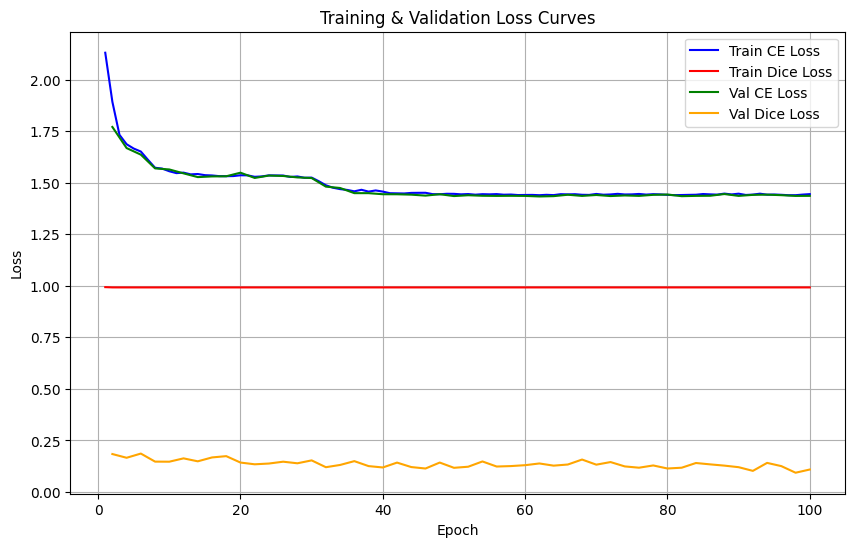

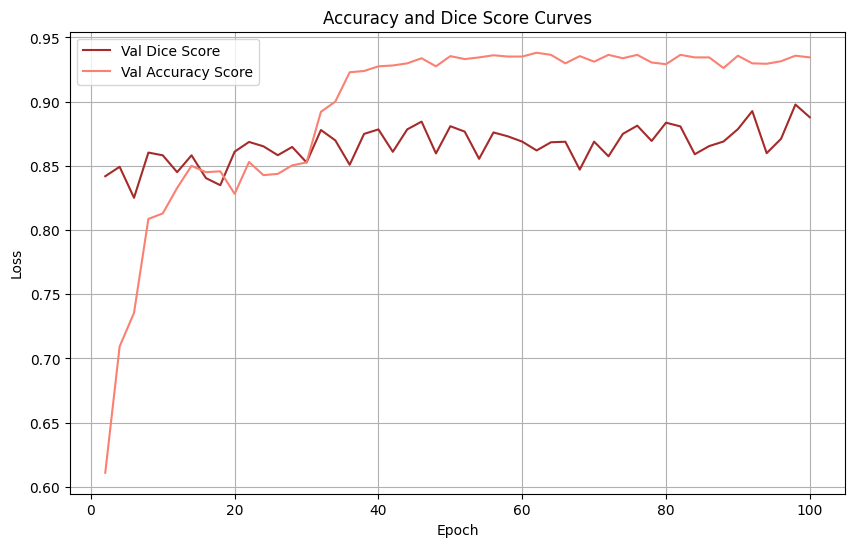

In [19]:
best_metric, best_metric_epoch, best_epoch_preds, best_epoch_labels = train(model, train_loader, val_loader, optimizer, loss_function, dice_metric, post_trans, writer, device, epoch_num, val_interval, early_stopping, patience, alpha, beta)

Visualization

for val_data in val_loader, we want val_segementation as the ground truth, which will be val_data[1]. Afterwards, to get the prediction, we can just use the functions that we defined above to get it. Afterwards, we can plot it.

In [20]:
def visualization(model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta):
  model.eval()
  val_total_loss, val_dice_loss, val_ce_loss = 0, 0, 0
  val_correct, val_total = 0, 0
  preds_list, labels_list = [], []

  with torch.no_grad():
    for val_data in val_loader:
      val_images, val_segmentations, val_cls_labels = (val_data[0].to(device), val_data[1].to(device), val_data[2].to(device))

      print("uqnie val segs, ", torch.unique(val_segmentations))

      seg, cls = model(val_images)

      print(torch.unique(seg))

      seg_output = post_trans(seg)
      print(torch.unique(seg_output))
      dice_metric(seg_output, val_segmentations)

      print(seg.shape)

      for pred, gt in zip(seg_output, val_segmentations):
        pred = pred.squeeze().cpu()
        gt = gt.squeeze().cpu()
        fig, ax = plt.subplots(ncols=2, nrows=1)
        ax[0].imshow(gt)
        ax[1].imshow(pred)

      break

uqnie val segs,  metatensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.9686, 0.9725, 0.9765, 0.9804, 0.9843, 0.9882, 0.9922, 0.9961, 1.0000],
       device='cuda:0')
metatensor([-30.0924, -29.6732, -29.2485,  ...,  31.6344,  31.7533,  31.9031],
       device='cuda:0')
metatensor([0., 1.], device='cuda:0')
torch.Size([32, 1, 224, 224])


<ipython-input-20-e4cabfb1206c>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=2, nrows=1)


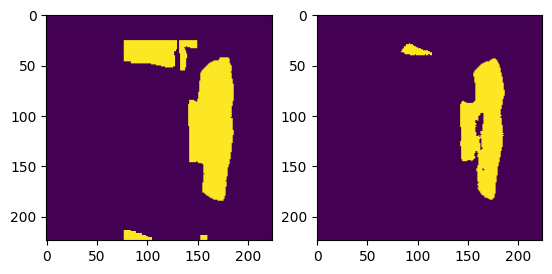

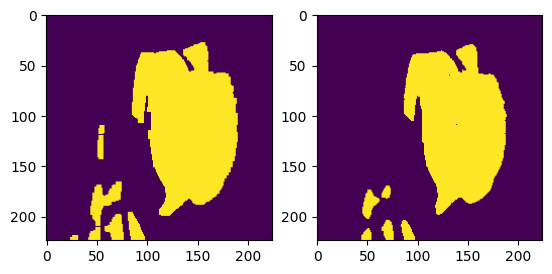

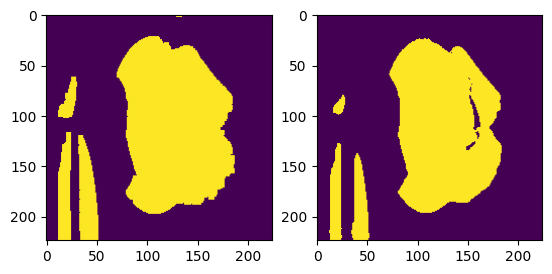

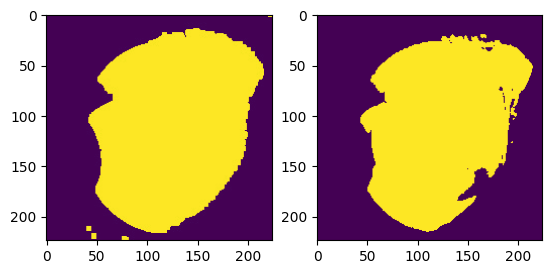

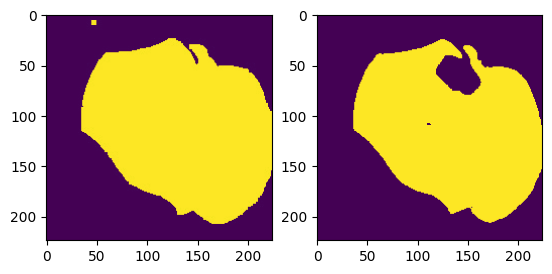

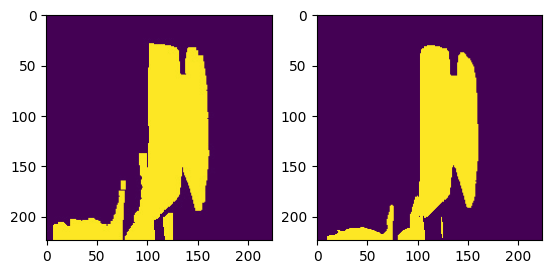

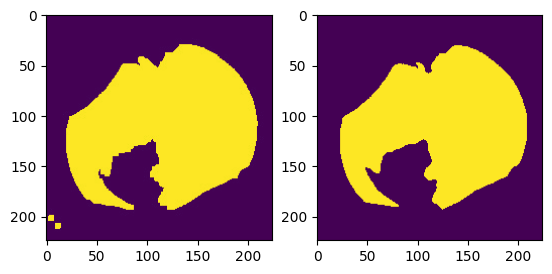

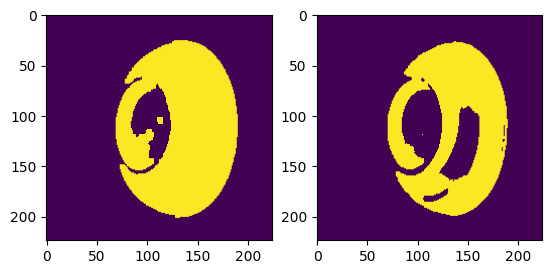

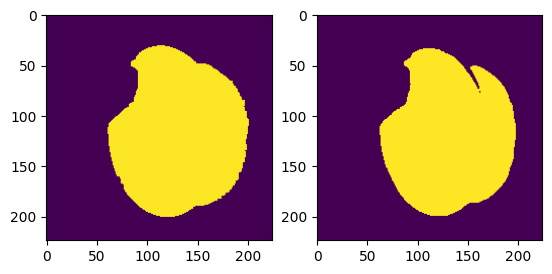

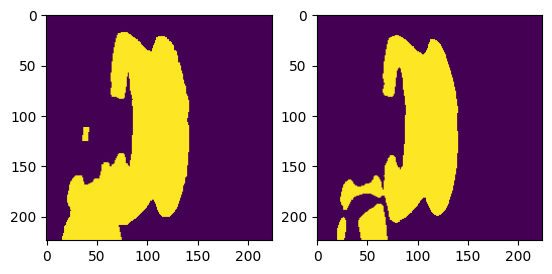

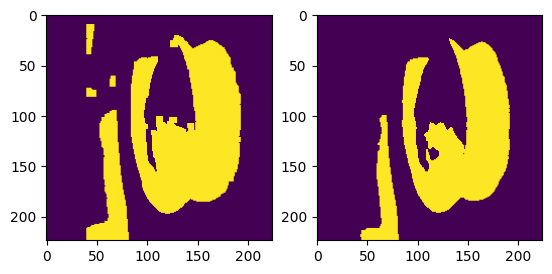

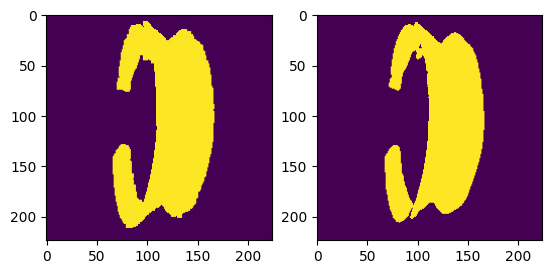

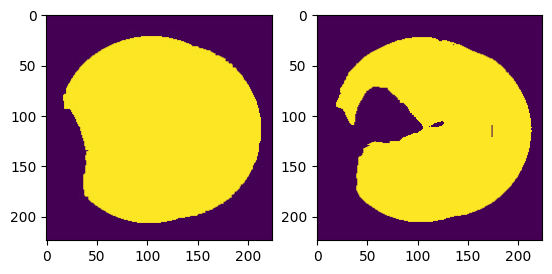

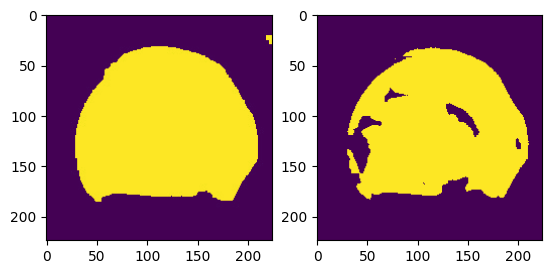

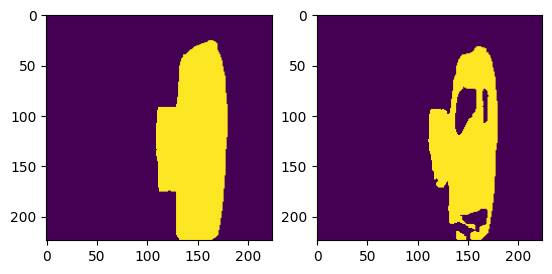

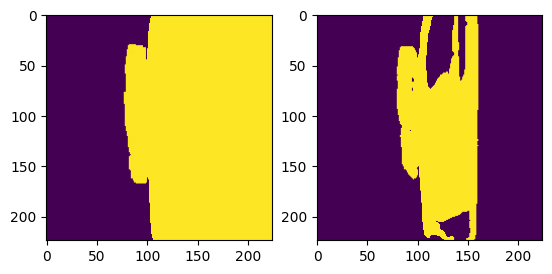

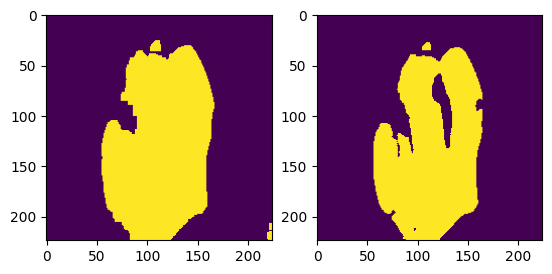

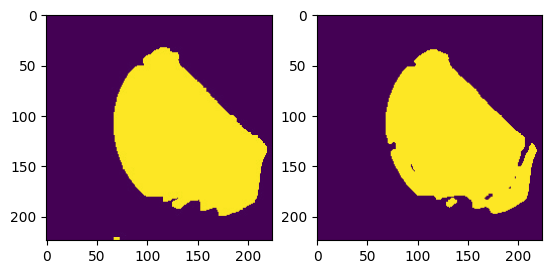

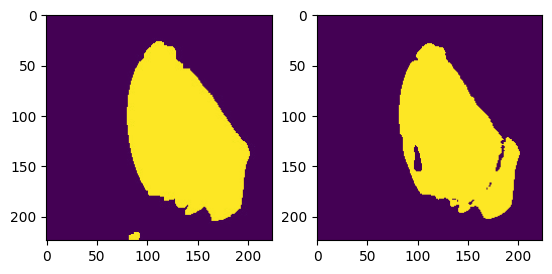

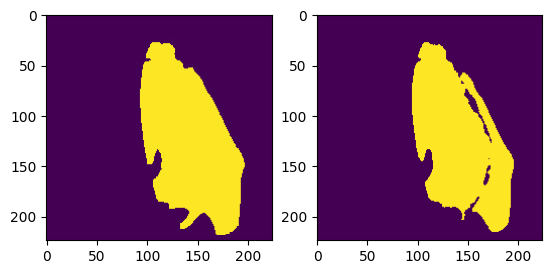

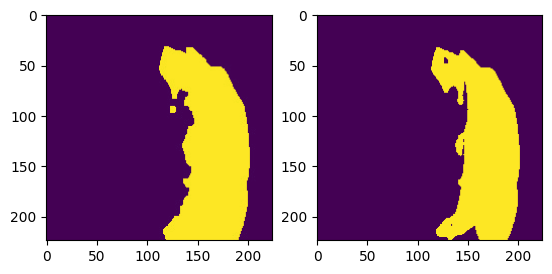

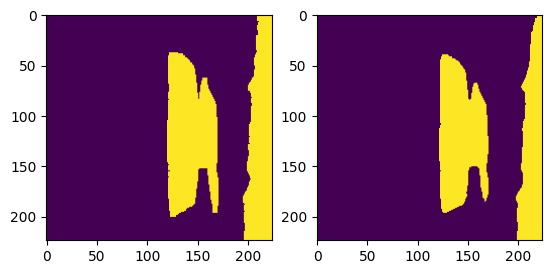

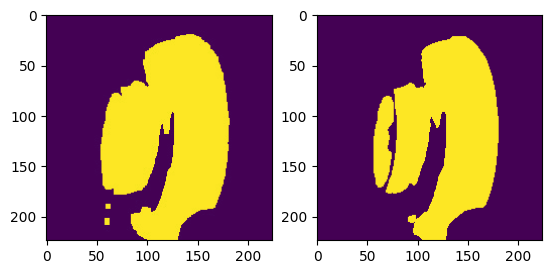

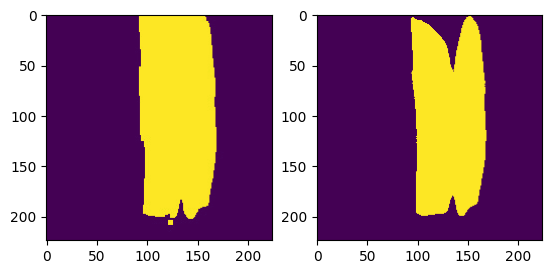

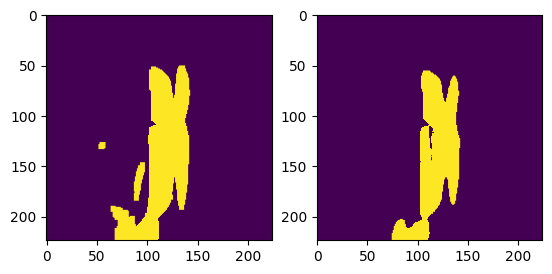

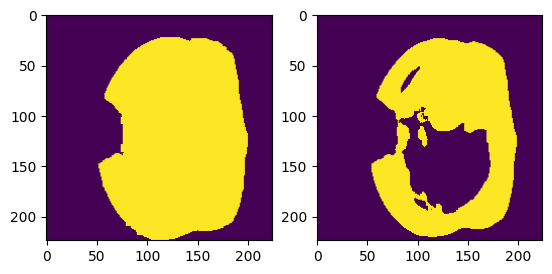

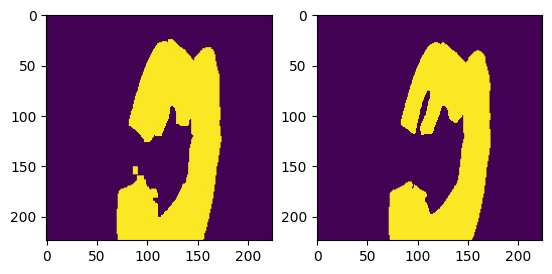

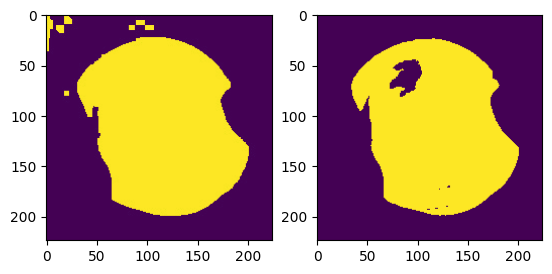

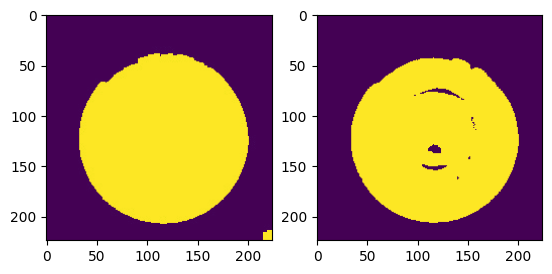

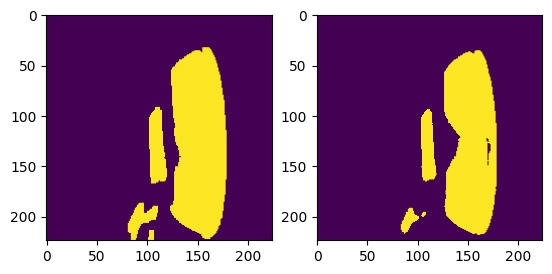

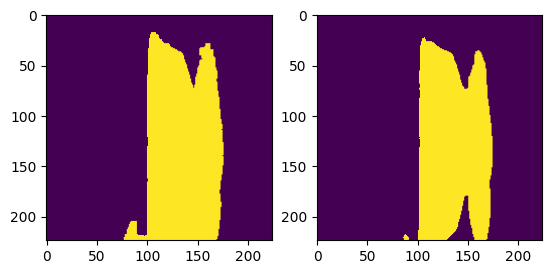

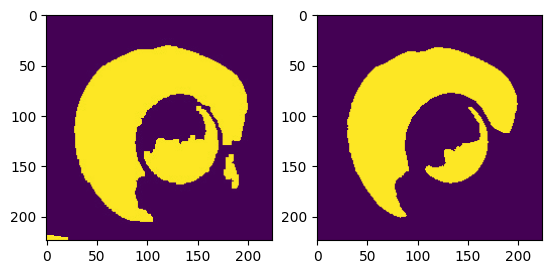

In [22]:
visualization(model, val_loader, loss_function, dice_metric, post_trans, writer, device, alpha, beta)